<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Fit-and-plot-neutralization-curves" data-toc-modified-id="Fit-and-plot-neutralization-curves-1">Fit and plot neutralization curves</a></span><ul class="toc-item"><li><span><a href="#Import-Python-modules-/-packages" data-toc-modified-id="Import-Python-modules-/-packages-1.1">Import Python modules / packages</a></span></li><li><span><a href="#Configuration-and-setup" data-toc-modified-id="Configuration-and-setup-1.2">Configuration and setup</a></span></li><li><span><a href="#Read-neutralization-data" data-toc-modified-id="Read-neutralization-data-1.3">Read neutralization data</a></span></li><li><span><a href="#Fit-and-plot-all-neutralization-curves" data-toc-modified-id="Fit-and-plot-all-neutralization-curves-1.4">Fit and plot all neutralization curves</a></span></li><li><span><a href="#Colored-plots-for-figures" data-toc-modified-id="Colored-plots-for-figures-1.5">Colored plots for figures</a></span></li></ul></li></ul></div>

# Fit and plot neutralization curves
In this notebook we will plot neutralization curves from GFP-based neutralization assays. 
The GFP-based neutralization assay system is described in detail [here](https://github.com/jbloomlab/flu_PB1flank-GFP_neut_assay).

All the curves plotted here represent the mean and standard deviation of three replicates, with each replicate in a separate column of a 96-well plate.

The curves fit are the Hill-style neutralization functions fit and plotted by the [neutcurve](https://jbloomlab.github.io/neutcurve/) package.

## Import Python modules / packages

In [1]:
import os
import warnings

from IPython.display import display, HTML

import matplotlib.pyplot as plt

import pandas as pd

import yaml

import neutcurve
from neutcurve.colorschemes import CBPALETTE
import neutcurve.parse_excel

print(f"Using neutcurve version {neutcurve.__version__}")

Using neutcurve version 0.2.dev0


Suppress warnings that can clutter output:

In [2]:
warnings.simplefilter('ignore')

## Configuration and setup
Read general configuration from [config.yaml](config.yaml), which in turn specifies additional configuration files:

In [3]:
with open('config.yaml') as f:
    config = yaml.safe_load(f)

Read the neutralization assay configuration from the specified file:

In [4]:
print(f"Reading neutralization assay setup from {config['neut_config']}")

with open(config['neut_config']) as f:
    neut_config = yaml.safe_load(f)

Reading neutralization assay setup from data/neut_assays/neut_config.yaml


Get the output directory:

In [5]:
outdir = config['neutresultsdir']
os.makedirs(outdir, exist_ok=True)
print(f"Output will be written to {outdir}")

Output will be written to results/neutralization_assays


## Read neutralization data

Next, for each dict in *neut_config*, we use [neutcurve.parse_excel.parseRachelStyle2019](https://jbloomlab.github.io/neutcurve/neutcurve.parse_excel.html#neutcurve.parse_excel.parseRachelStyle2019) to parse the raw Excel files to create a tidy data frame appropriate for passing to [neutcurve.CurveFits](https://jbloomlab.github.io/neutcurve/neutcurve.curvefits.html#neutcurve.curvefits.CurveFits). 
We then concatenate all the tidy data frames to get our neutralization data.
This is essentially the workflow [explained here](https://jbloomlab.github.io/neutcurve/rachelstyle2019_example.html):

In [6]:
neutdata = []  # store all data frame, then concatenate at end

for sampledict in neut_config:
    assert len(sampledict) == 1
    sampleset, kwargs = list(sampledict.items())[0]
    print(f"Parsing data for {sampleset}...")
    neutdata.append(neutcurve.parse_excel.parseRachelStyle2019(**kwargs))

neutdata = pd.concat(neutdata)
print(f"Read data for {len(neutdata.groupby('serum'))} sera and "
      f"{len(neutdata.groupby(['serum', 'virus']))} serum / virus pairs.")

Parsing data for VIDD1...
Parsing data for VIDD2...
Parsing data for VIDD3...
Parsing data for VIDD4...
Parsing data for VIDD5...
Parsing data for 557v1...
Parsing data for 557v2...
Parsing data for 574v1...
Parsing data for 574v2...
Parsing data for 589v1...
Parsing data for 589v2...
Parsing data for 571v1...
Parsing data for 571v2...
Parsing data for ferret-Pitt-1-preinf...
Parsing data for ferret-Pitt-1-postinf...
Parsing data for ferret-Pitt-2-preinf...
Parsing data for ferret-Pitt-2-postinf...
Parsing data for ferret-Pitt-3-preinf...
Parsing data for ferret-Pitt-3-postinf...
Parsing data for ferret-WHO...
Parsing data for ferret-WHO-Victoria2011...
Parsing data for antibody-5A01...
Parsing data for antibody-3C06...
Parsing data for antibody-3C04...
Parsing data for antibody-4C01...
Parsing data for antibody-4F03...
Parsing data for antibody-1C04...
Read data for 27 sera and 91 serum / virus pairs.


These data look like this:

In [7]:
display(HTML(neutdata.head().to_html(index=False)))

serum,virus,replicate,concentration,fraction infectivity
2010-age-21,wt,1,0.000024,1.010575
2010-age-21,wt,1,0.000046,0.981598
2010-age-21,wt,1,0.000086,0.997023
2010-age-21,wt,1,0.000163,0.954407
2010-age-21,wt,1,0.000308,1.005039


Write the neutralization data to a CSV file in our output directory:

In [8]:
neutdatafile = os.path.join(outdir, 'neutdata.csv')
neutdata.to_csv(neutdatafile, index=False)
print(f"Wrote neutralization data to {neutdatafile}")

Wrote neutralization data to results/neutralization_assays/neutdata.csv


## Fit and plot all neutralization curves

Now we fit the neutralization curves with a neutcurve.CurveFits:

In [9]:
fits = neutcurve.CurveFits(neutdata)

Make a big panel of plots of the across-replicate averages for all sera and antibodies:


Plotting all sera curves to results/neutralization_assays/all_sera_plots.pdf...


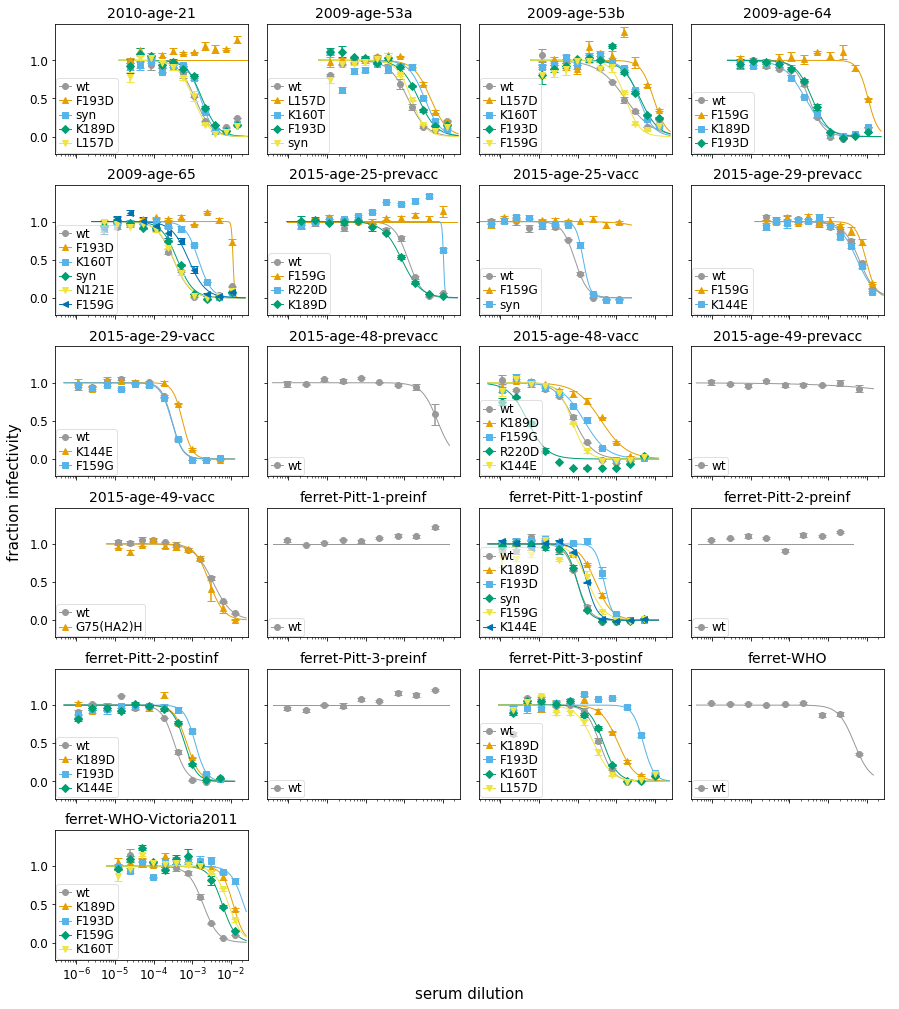


Plotting all antibody curves to results/neutralization_assays/all_antibody_plots.pdf...


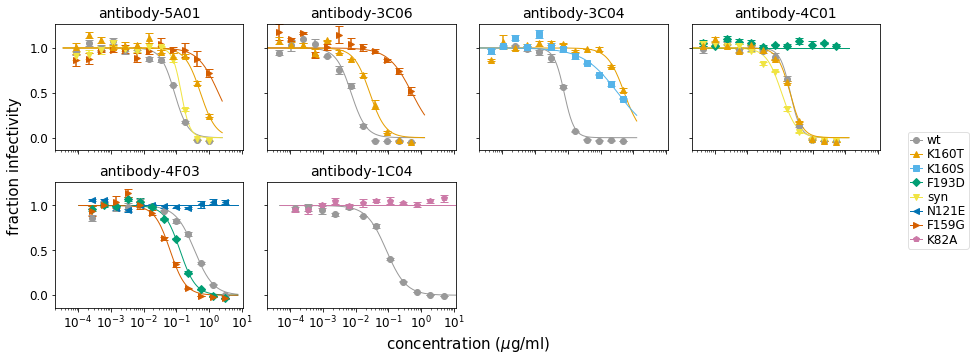

In [10]:
for is_antibody, ptype, xlabel in [(False, 'sera', 'serum dilution'),
                                   (True, 'antibody', 'concentration ($\mu$g/ml)')]:
    plotfile = os.path.join(outdir, f"all_{ptype}_plots.pdf")
    print(f"\nPlotting all {ptype} curves to {plotfile}...")
    fig, _ = fits.plotSera(
                sera=[s for s in fits.sera if ('antibody' in s) == is_antibody],
                xlabel=xlabel,
                max_viruses_per_subplot=6,
                )
    display(fig)
    fig.savefig(plotfile)
    plt.close(fig)

Now get the curve fit parameters (e.g., IC50s):

In [11]:
fitparams = fits.fitParams()

Here is a list of all of the IC50s for the replicate-averages for each serum / virus pair.
Note that for sera there are dilutions, and for antibodies that are $\mu$g/ml:

In [12]:
display(HTML(fitparams
             .query('replicate == "average"')
             .drop(columns=['midpoint', 'top', 'bottom', 'replicate',
                            'ic50', 'ic50_bound', 'slope', 'nreplicates'])
             .to_html(index=False)
             ))

serum,virus,ic50_str
2010-age-21,wt,0.00118
2010-age-21,F193D,>0.014
2010-age-21,syn,0.00164
2010-age-21,K189D,0.0018
2010-age-21,L157D,0.00107
2009-age-53a,wt,0.00124
2009-age-53a,L157D,0.00481
2009-age-53a,K160T,0.00338
2009-age-53a,F193D,0.00234
2009-age-53a,syn,0.00153


Write all of the fit parameters (including IC50s) for all replicates to a file:

In [13]:
fitfile = os.path.join(outdir, 'fitparams.csv')
print(f"Writing fit parameters to {fitfile}")
fitparams.to_csv(fitfile, index=False, float_format='%.3g')

Writing fit parameters to results/neutralization_assays/fitparams.csv


## Colored plots for figures
Get the colors that we have specified for viruses in each serum group:

In [14]:
with open(config['mutation_colors_and_markers']) as f:
    virus_to_color_marker = yaml.safe_load(f)

Specify the extensions for the figure files:

In [15]:
fig_extensions = ['.svg', '.pdf']

Write figures to this directory:

In [16]:
figsdir = config['figsdir']
os.makedirs(figsdir, exist_ok=True)

Get data frame with all sera:

In [17]:
with open(config['serum_info']) as f:
    sera_df = (pd.DataFrame.from_dict(yaml.safe_load(f))
               .transpose()
               .rename_axis('serum')
               .reset_index()
               .assign(name=lambda x:
                            x['species'].map(lambda s: '' if pd.isnull(s) or
                                             s == 'human' else s + '-') +
                            x['name']
                       )
               )

Now draw the plots as single-column figures so they can be combined with the logo plots:


**************** Hensley_sera ****************


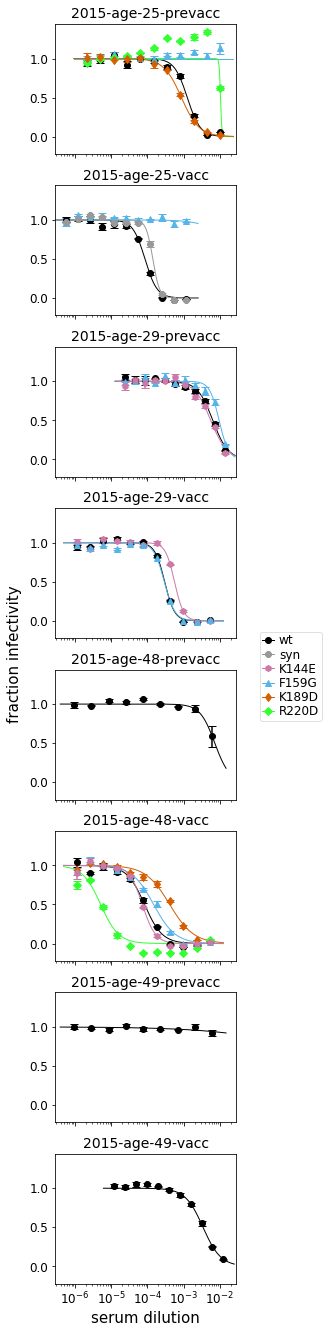

Saving to results/figures/Hensley_sera_neut.svg
Saving to results/figures/Hensley_sera_neut.pdf

**************** VIDD_sera ****************


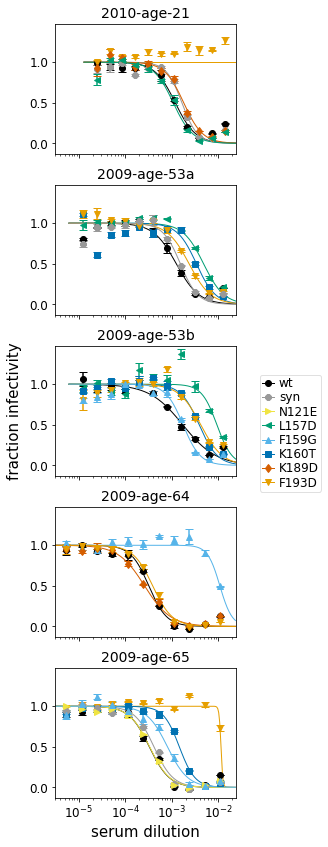

Saving to results/figures/VIDD_sera_neut.svg
Saving to results/figures/VIDD_sera_neut.pdf

**************** antibody_lower_head ****************


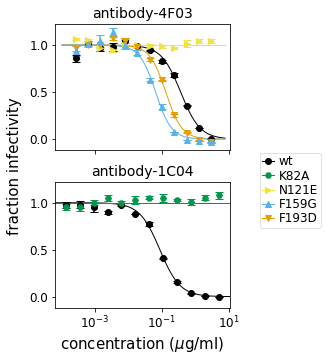

Saving to results/figures/antibody_lower_head_neut.svg
Saving to results/figures/antibody_lower_head_neut.pdf

**************** antibody_region_B ****************


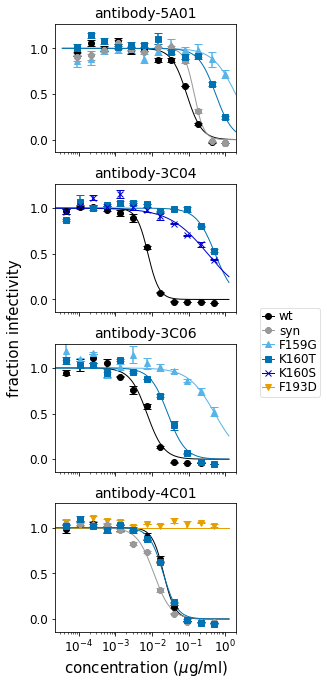

Saving to results/figures/antibody_region_B_neut.svg
Saving to results/figures/antibody_region_B_neut.pdf

**************** ferret ****************


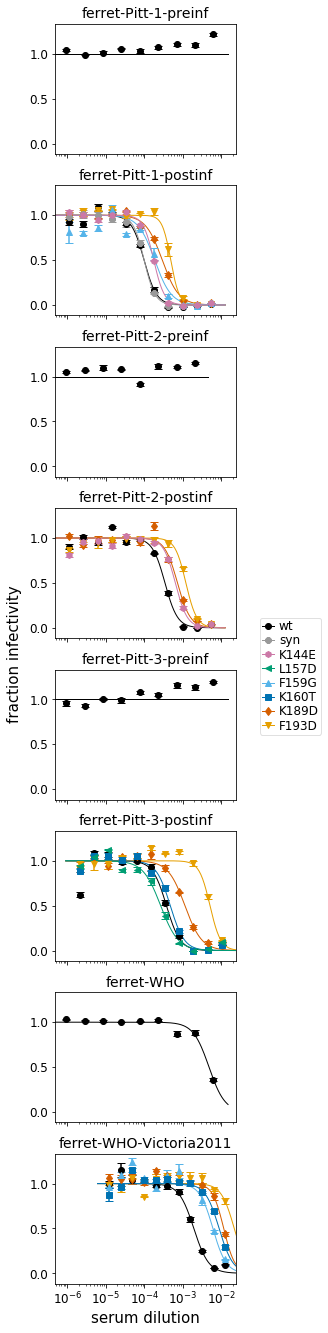

Saving to results/figures/ferret_neut.svg
Saving to results/figures/ferret_neut.pdf


In [18]:
for serum_group, df in sera_df.groupby('group'):
    if serum_group not in virus_to_color_marker:
        continue
    sera = df['name'].unique()
    if 'antibody' in serum_group:
        xlabel = 'concentration ($\mu$g/ml)'
    else:
        xlabel = 'serum dilution'
    colors = virus_to_color_marker[serum_group]['colors']
    print(f"\n**************** {serum_group} ****************")
    fig, _ = fits.plotSera(
                sera=df['name'].unique(),
                viruses=colors.keys(),
                virus_to_color_marker=colors,
                xlabel=xlabel,
                max_viruses_per_subplot=len(colors),
                ncol=1,
                )
    display(fig)
    for ext in fig_extensions:
        plotfile = os.path.join(config['figsdir'], f"{serum_group}_neut{ext}")
        print(f"Saving to {plotfile}")
        fig.savefig(plotfile)
    plt.close(fig)